In [274]:
#Importing required libraries
import pandas as pd
import numpy as np
from pandas_datareader import data
import requests
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline


In [275]:
portfolio = 1e5 #Portfolio total worth of 1 lakh
tscost = 0.005 #Per trade transaction cost of 0.5%, so if two stocks of 30 each are bought, (1+0.005)*2*30 is charged in total
nstocks = 0

stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS'] #Stock list, to add a stock simply
                                                                           #add the ticker according to Yahoo! Finance
for stock in stock_list:
    nstocks+=1          #Calculates number of stocks according to input stock list

In [276]:
#Function to read Data
def readData(ticker, n):
    stocks.append(data.DataReader(ticker, 'yahoo',start='1/1/2015')) #Taking backtesting period as roughly 5 years

# RSI Indicator

In [277]:
def RSI(df1):
    temp=df1['Adj Close'].diff()
    diff_values=temp[~np.isnan(temp)]
    o=df1['Open'].tolist()
    c=np.zeros(len(df1))
    df1['Position'] = 0
    
    
    a=diff_values.index.tolist()
    b=diff_values.tolist()
    c=np.zeros(len(df1))
   
    RSI=pd.DataFrame()

    count=0
    for count in range(0,len(df1)-13):
        
        Total_loss=0
        Total_gain=0
        for i in range(count,count+13):
            if(b[i]>0):
                Total_gain+=b[i]
                #print('Gain ',Total_gain)
            
            elif(b[i]<0):
                Total_loss-=b[i]
                
            if(Total_loss!=0):
                RS=Total_gain/Total_loss
                
                
            
        RSI_Val=100-(100/(1+RS))
        
        c[count+13]=RSI_Val
        
    
    df1['RSI']=c
   

# Stochastic Oscillator

In [278]:
#          If The 3 day moving average of %k defined as (Current close-lowest low(14D))/(Highest high(14D)-Lowest Low(14D))
#           is above a certain value like say 90 as done in strategy it is in overbought and must be shorted and below 10 is 
#           considered oversold hence we must go long


def StochasticOscillator(df1):
    num_rows=df.shape[0]
    h=df1['High'].tolist()#creating a temporary list containg adjusted high of each day 
    c=df1['Close'].tolist()#list containing adjusted close prices
    lw=df1['Low'].tolist()#List containg adjusted low prices
    b=np.zeros(len(df1))#Empty temporary array

    count=0# Will be used to access each index of the list 


    for count in range(0,len(df1)-15):

        MaxHigh=0#Used to store maximum high of 14 day period
        MinLow=lw[count]#We are arbitrarily choosing lowest price of 1st day of 14 day period as minimum low for each period
    
        for i in range(count,count+15):
            if(h[i]>MaxHigh):
                MaxHigh=h[i]#Storing Maximum high
            
            
            if(lw[i]<MinLow):
                MinLow=lw[i]#Storing Minimum low
    
        k=((c[count+13]-MinLow)/(MaxHigh-MinLow))#calculating the stochastic oscillator
    
        b[count+15]=(k*100)#Storing values of stochastic oscillator conerting value to range in between 100 and 0.
 
    df1['%k']=b
    window=3
    FSD=df1['%k'].rolling(window).mean()
    df1['%d']=FSD


In [279]:
# WE HAVE USED STOCHASTIC OSCILLATOR AND RSI INDICATOR BECAUSE STOCHASTIC OSCILLATOR IS USED IN SIDEWAYS MARKET AND
# RSI IS USED IN VOLATILE MARKETS AS THEY ARE MOMENTUM INDICATORS THEY AREN'T IDEAL TO BE USED AS THE SOLE JUDGE. HENCE
# WE USED A COMBINATION OF 2 TYPES OF MOMENTUM INDICATORS TO GENERATE A DECENT PROFIT.

def Strategy(df1):
    for row in range(len(df1)):
        if(df1['Position'].iloc[row-1]==0):
            if ((df1['RSI'].iloc[row] < 26) or (df1['%d'].iloc[row] < 10)):
                df1['Position'].iloc[row] = -1

            if ((df1['RSI'].iloc[row] > 86) or (df1['%d'].iloc[row] > 90)):
                df1['Position'].iloc[row] = 1

            
        elif (df1['Position'].iloc[row-1]==1):
            if ((df1['RSI'].iloc[row] > 86) or (df1['%d'].iloc[row] > 90)):
                df1['Position'].iloc[row] = -1
            else:
                df1['Position'].iloc[row] = 0

        else:
            if ((df1['RSI'].iloc[row] < 26) or (df1['RSI'].iloc[row] < 10)):
                df1['Position'].iloc[row] = -1
            else:
                df1['Position'].iloc[row] = 0


In [280]:

#Iterating over all the tickers to read data, generate Bollinger Bands and formulate portfolio positions based on strategy
i = 0
stocks = []
for ticker in stock_list:
    readData(ticker,i)
    RSI(stocks[i])
    StochasticOscillator(stocks[i])
    Strategy(stocks[i])
    i+=1

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


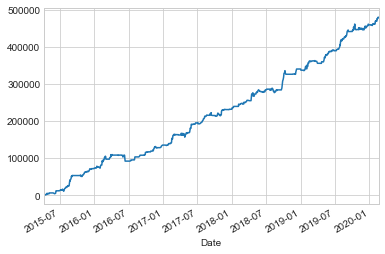

In [281]:
s = (len(stocks[0]),nstocks) #setting the dimensions of the weights vector depending on the available data points
weights = np.zeros(s) 


for row in range(len(stocks[0])):
    i = 0
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['Position'].iloc[row]) #checking how many positions were taken on that day
    for i in range(nstocks):
        if sumwts>0:
            #weights assigned as:
            #weights = (portfolio*position)/(no.of positions * adj close on that day * (1+transac cost))
            weights[row][i]=(portfolio*stocks[i]['Position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))
        else:
            weights[row][i]=0
i = 0


for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1)) #Absolute market return
    #Personal Addendum, .shift(n) shifts control forward or backward by n rows depending on sign.

    
#Calculating portfolio return
stocks[0]['Strategy Return']=0
i = 0
for i in range(nstocks):
    stocks[0]['Strategy Return']+=stocks[i]['Market Return'] * weights[:,i] #multiplying market return of each
                                                                            #ticker with its weight
stocks[0]['Strategy Return'][64:].cumsum().plot() #Plotting strategy return

In [282]:
weights

array([[ -124.56393801,   -90.78107176,   -14.31366783,   -48.09259025,
         -988.53579938],
       [ -121.50978256,   -90.49786318,   -14.28268834,   -48.2202173 ,
         -961.93088853],
       [ -122.35378819,   -90.1428432 ,   -14.30265965,   -48.75425366,
         -955.99090809],
       ...,
       [-1433.75339156,  -244.05809316,     0.        ,     0.        ,
            0.        ],
       [-1405.40230612,  -240.69300685,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ]])